# Transformer Trading Model - IEX DEEP Data
## IE 421: Agentic AI in Financial Markets
 
**Model:** Transformer for Price Prediction  
**Data Source:** IEX DEEP from UIUC Campus Cluster

## 📋 Table of Contents

1. [Setup & Imports](#setup)
2. [Load IEX Data](#load-data)
3. [Aggregate to OHLCV Bars](#aggregate)
4. [Feature Engineering](#features)
5. [Initialize Model](#initialize)
6. [Prepare Data](#prepare)
7. [Train Model](#train)
8. [Evaluate & Backtest](#evaluate)
9. [Visualize Results](#visualize)
10. [Experiments & Tuning](#experiments)

## 1. Setup & Imports {#setup}

Importing all necessary libraries and checking the setup.

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Deep learning
import torch
import torch.nn as nn

# Our custom model
from transformer_trading_model import TransformerTrader

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✓ All imports successful!
PyTorch version: 2.8.0+cpu
CUDA available: False
Device: cpu


## 2. Load IEX Data {#load-data}

Load tick data from the IEX DEEP format (from campus cluster).

In [2]:
def load_iex_tick_data(filepath, symbol='AAPL'):
    """
    Load IEX DEEP tick data from campus cluster format.
    """
    print(f"Loading IEX tick data from {filepath}...")
    
    df = pd.read_csv(
        filepath,
        compression='gzip',
        header=None,
        names=['timestamp_capture', 'timestamp_event', 'seq_id', 'msg_type',
               'exchange', 'field1', 'price', 'size', 'field2', 'field3',
               'field4', 'field5'],
        on_bad_lines='skip'
    )
    
    # Convert timestamps
    df['timestamp_event'] = pd.to_datetime(df['timestamp_event'], unit='ns')
    df['timestamp_capture'] = pd.to_datetime(df['timestamp_capture'], unit='ns')
    
    # Sort by event timestamp
    df = df.sort_values('timestamp_event').reset_index(drop=True)
    
    print(f"✓ Loaded {len(df):,} records")
    print(f"  - Trades (T): {len(df[df['msg_type'] == 'T']):,}")
    print(f"  - Price updates (P): {len(df[df['msg_type'] == 'P']):,}")
    print(f"  - Date range: {df['timestamp_event'].min()} to {df['timestamp_event'].max()}")
    
    return df

In [3]:
# Path to your IEX data folder
data_path = r'C:\Users\naina\OneDrive\Desktop\UIUC\Fall 2025\IE 421\IE 421 project\iex_data'

# Load all 3 days of AAPL data
dates = ['20251020', '20251021', '20251022']
all_data = []

print("Loading IEX DEEP data for AAPL (October 20-22, 2025)...")
print("="*60)

for date in dates:
    filepath = f'{data_path}\\tick_AAPL_{date}.txt.gz'
    print(f"\nLoading {date}...")
    df = load_iex_tick_data(filepath, symbol='AAPL')
    all_data.append(df)

# Combine all 3 days
df_tick = pd.concat(all_data, ignore_index=True)
df_tick = df_tick.sort_values('timestamp_event').reset_index(drop=True)

print("\n" + "="*60)
print(f"✓ Combined dataset: {len(df_tick):,} total records")
print(f"  Date range: {df_tick['timestamp_event'].min()} to {df_tick['timestamp_event'].max()}")
print(f"  Trades: {len(df_tick[df_tick['msg_type'] == 'T']):,}")
print(f"  Price updates: {len(df_tick[df_tick['msg_type'] == 'P']):,}")
print("="*60)

# Preview
df_tick.head()

Loading IEX DEEP data for AAPL (October 20-22, 2025)...

Loading 20251020...
Loading IEX tick data from C:\Users\naina\OneDrive\Desktop\UIUC\Fall 2025\IE 421\IE 421 project\iex_data\tick_AAPL_20251020.txt.gz...
✓ Loaded 1,916,065 records
  - Trades (T): 32,877
  - Price updates (P): 1,883,188
  - Date range: 2025-10-20 12:28:01.608728050 to 2025-10-20 20:59:34.331654847

Loading 20251021...
Loading IEX tick data from C:\Users\naina\OneDrive\Desktop\UIUC\Fall 2025\IE 421\IE 421 project\iex_data\tick_AAPL_20251021.txt.gz...
✓ Loaded 1,515,967 records
  - Trades (T): 22,917
  - Price updates (P): 1,493,050
  - Date range: 2025-10-21 12:00:08.865404561 to 2025-10-21 20:56:01.183463434

Loading 20251022...
Loading IEX tick data from C:\Users\naina\OneDrive\Desktop\UIUC\Fall 2025\IE 421\IE 421 project\iex_data\tick_AAPL_20251022.txt.gz...
✓ Loaded 1,775,958 records
  - Trades (T): 25,335
  - Price updates (P): 1,750,623
  - Date range: 2025-10-22 12:17:07.920172347 to 2025-10-22 20:08:52.248

,timestamp_capture,timestamp_event,seq_id,msg_type,exchange,field1,price,size,field2,field3,field4,field5
0,2025-10-20 12:28:38.608745984,2025-10-20 12:28:01.608728050,158720,T,IEX,256.27,9.0,NaN,NaN,NaN,NaN,NaN
1,2025-10-20 12:30:49.428577024,2025-10-20 12:30:12.428558740,167870,T,IEX,256.61,100.0,NaN,NaN,NaN,NaN,NaN
2,2025-10-20 12:30:49.428610048,2025-10-20 12:30:12.428593809,167871,T,IEX,256.62,50.0,NaN,NaN,NaN,NaN,NaN
3,2025-10-20 12:34:24.603362048,2025-10-20 12:33:47.603344502,186608,T,IEX,256.70,100.0,NaN,NaN,NaN,NaN,NaN
4,2025-10-20 12:34:52.990010112,2025-10-20 12:34:15.989988953,189869,T,IEX,256.64,100.0,NaN,NaN,NaN,NaN,NaN


In [4]:
# Quick statistics
trades = df_tick[df_tick['msg_type'] == 'T']

print("Trade Statistics:")
print(f"  Price range: ${trades['price'].min():.2f} - ${trades['price'].max():.2f}")
print(f"  Mean price: ${trades['price'].mean():.2f}")
print(f"  Total volume: {trades['size'].sum():,}")
print(f"  Mean trade size: {trades['size'].mean():.1f}")

Trade Statistics:
  Price range: $1.00 - $15730.00
  Mean price: $76.28
  Total volume: 0.0
  Mean trade size: nan


## 3. Aggregate to OHLCV Bars {#aggregate}

Convert tick data into OHLCV (Open, High, Low, Close, Volume) bars.

In [5]:
def aggregate_to_bars(df, interval='1min'):
    """
    Aggregate tick data into OHLCV bars.
    
    Parameters:
    - interval: '30S' (30 sec), '1min', '5min', etc.
    """
    print(f"Aggregating to {interval} bars...")
    
    # Filter for trades only
    trades = df[df['msg_type'] == 'T'].copy()
    
    if len(trades) == 0:
        raise ValueError("No trades found in data!")
    
    # Set timestamp as index
    trades.set_index('timestamp_event', inplace=True)
    
    # Create OHLCV bars
    ohlcv = pd.DataFrame()
    ohlcv['open'] = trades['price'].resample(interval).first()
    ohlcv['high'] = trades['price'].resample(interval).max()
    ohlcv['low'] = trades['price'].resample(interval).min()
    ohlcv['close'] = trades['price'].resample(interval).last()
    ohlcv['volume'] = trades['size'].resample(interval).sum()
    ohlcv['n_trades'] = trades['price'].resample(interval).count()
    
    # Forward fill missing values
    ohlcv['close'] = ohlcv['close'].fillna(method='ffill')
    ohlcv['open'] = ohlcv['open'].fillna(ohlcv['close'])
    ohlcv['high'] = ohlcv['high'].fillna(ohlcv['close'])
    ohlcv['low'] = ohlcv['low'].fillna(ohlcv['close'])
    ohlcv['volume'] = ohlcv['volume'].fillna(0)
    ohlcv['n_trades'] = ohlcv['n_trades'].fillna(0)
    
    # Reset index
    ohlcv.reset_index(inplace=True)
    ohlcv.rename(columns={'timestamp_event': 'timestamp'}, inplace=True)
    
    # Drop NaN
    ohlcv = ohlcv.dropna()
    
    print(f"✓ Created {len(ohlcv):,} bars")
    
    return ohlcv

In [6]:
# Aggregate to 1-minute bars (you can change this!)
df_ohlcv = aggregate_to_bars(df_tick, interval='1min')

# Preview
df_ohlcv.head(10)

Aggregating to 1min bars...
✓ Created 3,341 bars


,timestamp,open,high,low,close,volume,n_trades
0,2025-10-20 12:28:00,9.0,9.0,9.0,9.0,0.0,1
1,2025-10-20 12:29:00,9.0,9.0,9.0,9.0,0.0,0
2,2025-10-20 12:30:00,100.0,100.0,50.0,50.0,0.0,2
3,2025-10-20 12:31:00,50.0,50.0,50.0,50.0,0.0,0
4,2025-10-20 12:32:00,50.0,50.0,50.0,50.0,0.0,0
5,2025-10-20 12:33:00,100.0,100.0,100.0,100.0,0.0,1
6,2025-10-20 12:34:00,100.0,100.0,100.0,100.0,0.0,1
7,2025-10-20 12:35:00,100.0,100.0,100.0,100.0,0.0,0
8,2025-10-20 12:36:00,100.0,100.0,100.0,100.0,0.0,0
9,2025-10-20 12:37:00,100.0,100.0,100.0,100.0,0.0,1


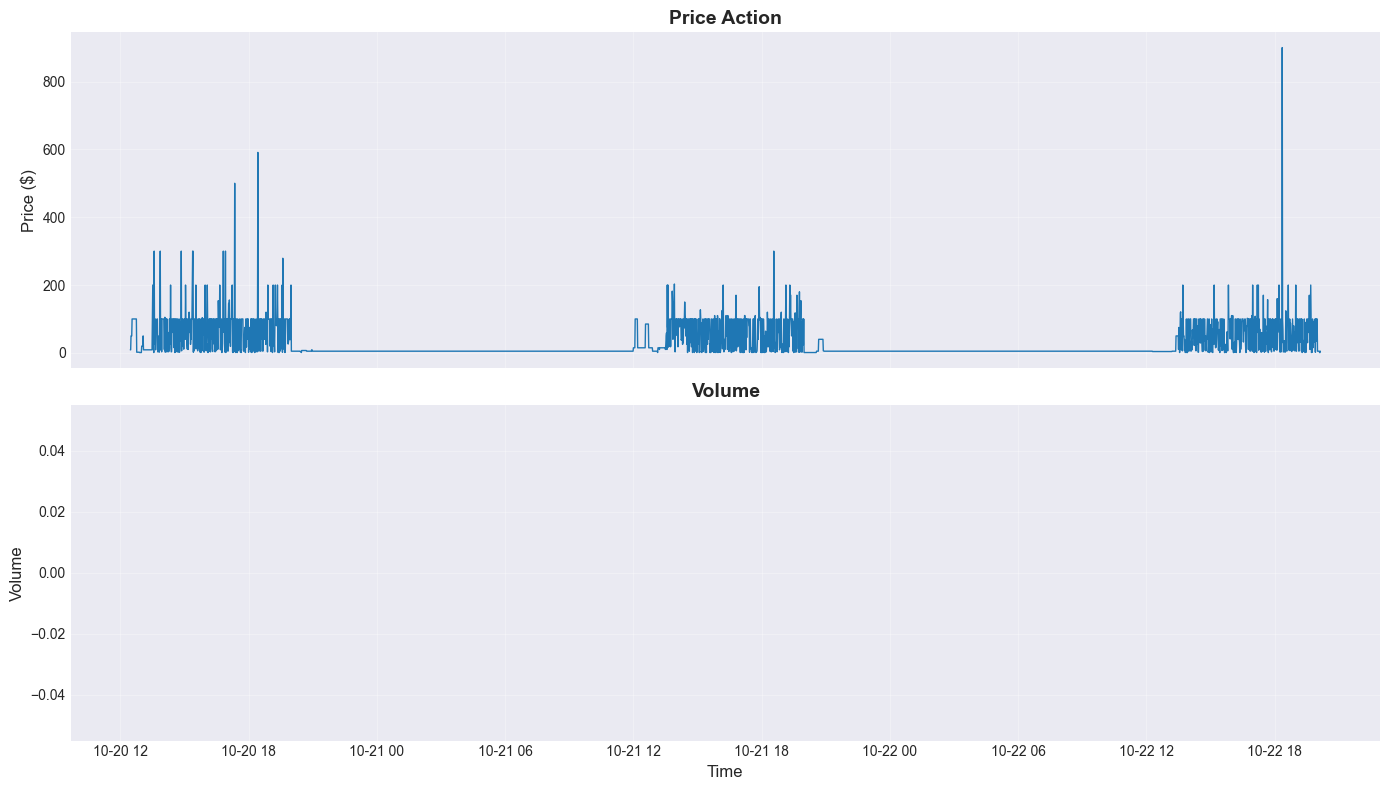

In [7]:
# Visualize the price action
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price
ax1.plot(df_ohlcv['timestamp'], df_ohlcv['close'], linewidth=1)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('Price Action', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Volume
ax2.bar(df_ohlcv['timestamp'], df_ohlcv['volume'], width=0.0005, alpha=0.6)
ax2.set_ylabel('Volume', fontsize=12)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_title('Volume', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Feature Engineering {#features}

Create 30+ technical features for the model.

In [8]:
def prepare_ml_features_short(ohlcv):
    """
    Prepare features with SHORT rolling windows.
    """
    print("Engineering features...")
    
    df = ohlcv.copy()
    df['price'] = df['close']
    
    # Basic returns
    df['return'] = df['price'].pct_change()
    df['log_return'] = np.log(df['price'] / df['price'].shift(1))
    
    # Short moving averages
    df['sma_5'] = df['price'].rolling(window=5).mean()
    df['sma_10'] = df['price'].rolling(window=10).mean()
    
    # Volume features
    df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_ratio'] = df['volume'] / (df['volume_ma_5'] + 1e-8)
    
    # Volatility
    df['volatility_5'] = df['return'].rolling(window=5).std()
    df['volatility_10'] = df['return'].rolling(window=10).std()
    
    # High-Low range
    df['hl_range'] = (df['high'] - df['low']) / (df['close'] + 1e-8)
    
    # Simple momentum
    df['momentum_5'] = df['price'] - df['price'].shift(5)
    
    # Target
    df['future_return'] = df['return'].shift(-1)
    
    # Drop NaN - only first 10 rows should be dropped
    initial_len = len(df)
    df = df.dropna()
    final_len = len(df)
    
    print(f"✓ Initial bars: {initial_len:,}")
    print(f"✓ After dropping NaN: {final_len:,}")
    print(f"✓ Features created: {len(df.columns)}")
    
    return df

In [9]:
# Use short window features
df_features = prepare_ml_features_short(df_ohlcv)

# Check the result
print(f"\nFinal dataset: {len(df_features):,} samples")
df_features.head()

Engineering features...
✓ Initial bars: 3,341
✓ After dropping NaN: 3,330
✓ Features created: 19

Final dataset: 3,330 samples


,timestamp,open,high,low,close,volume,n_trades,price,return,log_return,sma_5,sma_10,volume_ma_5,volume_ratio,volatility_5,volatility_10,hl_range,momentum_5,future_return
10,2025-10-20 12:38:00,100.0,100.0,100.0,100.0,0.0,0,100.0,0.0,0.0,100.0,75.9,0.0,0.0,0.0,1.440165,0.0,0.0,0.0
11,2025-10-20 12:39:00,100.0,100.0,100.0,100.0,0.0,0,100.0,0.0,0.0,100.0,85.0,0.0,0.0,0.0,1.440165,0.0,0.0,0.0
12,2025-10-20 12:40:00,100.0,100.0,100.0,100.0,0.0,0,100.0,0.0,0.0,100.0,90.0,0.0,0.0,0.0,0.316228,0.0,0.0,0.0
13,2025-10-20 12:41:00,100.0,100.0,100.0,100.0,0.0,0,100.0,0.0,0.0,100.0,95.0,0.0,0.0,0.0,0.316228,0.0,0.0,0.0
14,2025-10-20 12:42:00,100.0,100.0,100.0,100.0,0.0,0,100.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.316228,0.0,0.0,0.0


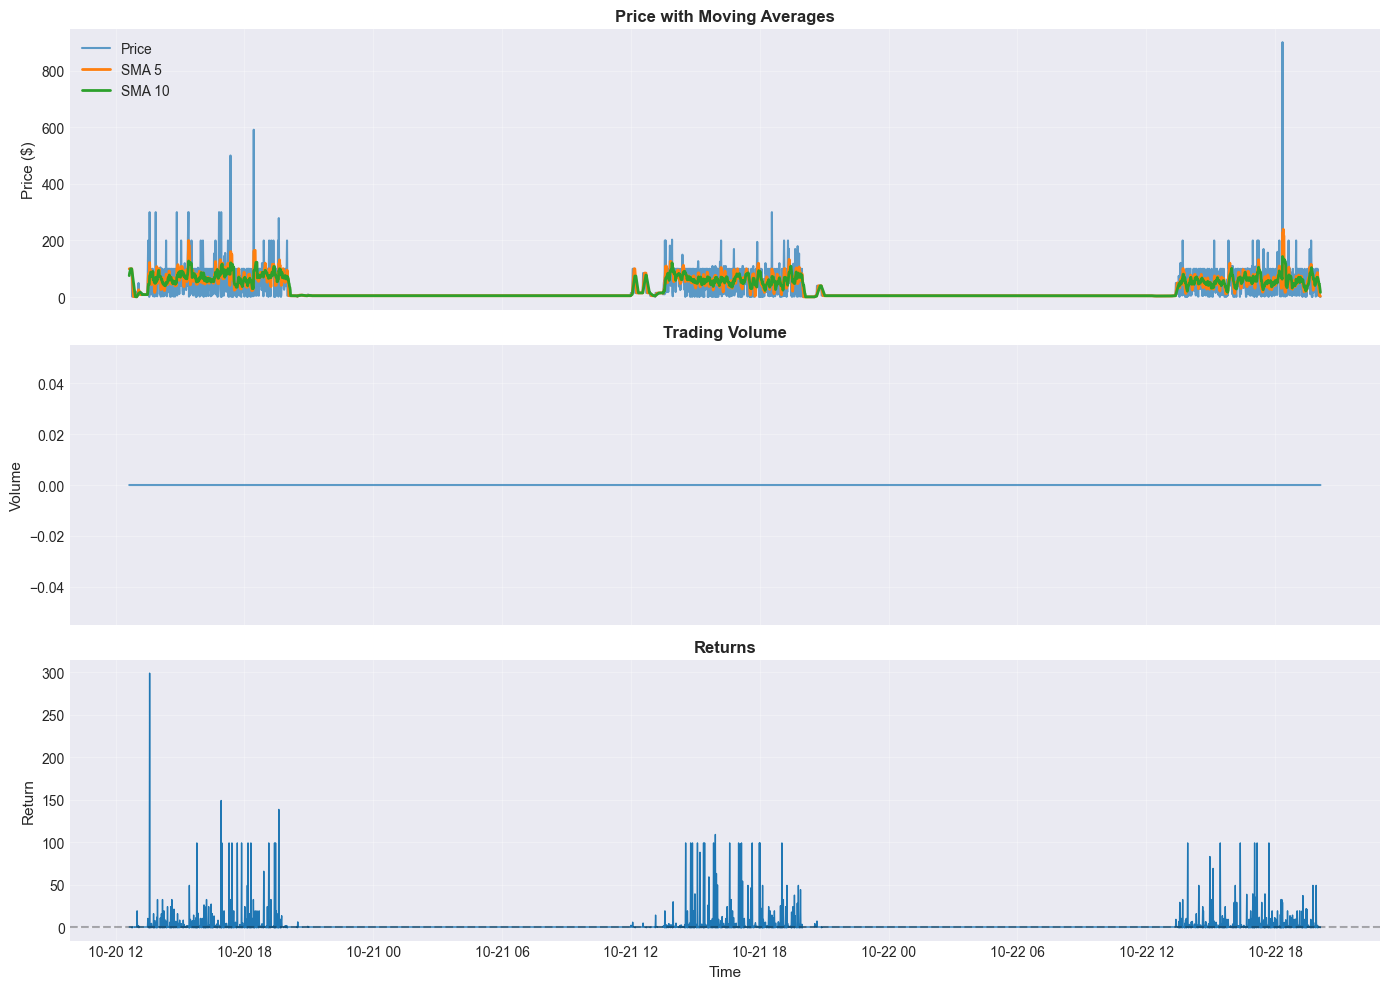

In [10]:
# Visualize some features
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Price with moving averages
axes[0].plot(df_features['timestamp'], df_features['price'], label='Price', alpha=0.7)
axes[0].plot(df_features['timestamp'], df_features['sma_5'], label='SMA 5', linewidth=2)
axes[0].plot(df_features['timestamp'], df_features['sma_10'], label='SMA 10', linewidth=2)  # Changed from sma_20
axes[0].set_ylabel('Price ($)', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Price with Moving Averages', fontweight='bold')

# Volume
axes[1].plot(df_features['timestamp'], df_features['volume'], alpha=0.7)
axes[1].set_ylabel('Volume', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Trading Volume', fontweight='bold')

# Returns
axes[2].plot(df_features['timestamp'], df_features['return'], linewidth=1)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[2].set_ylabel('Return', fontsize=11)
axes[2].set_xlabel('Time', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].set_title('Returns', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Initialize Model {#initialize}

Create the Transformer model with chosen hyperparameters.

In [11]:
# Simplified feature list
feature_columns = [
    'return', 'log_return',
    'sma_5', 'sma_10',
    'volume', 'volume_ma_5', 'volume_ratio',
    'volatility_5', 'volatility_10',
    'hl_range',
    'momentum_5',
    'n_trades'
]

print(f"Using {len(feature_columns)} features")

Using 12 features


In [12]:
# Initialize the Transformer trader
trader = TransformerTrader(
    sequence_length=50,      # Look back 50 time steps
    d_model=128,             # Model dimension
    n_heads=8,               # Number of attention heads
    n_layers=4,              # Number of Transformer layers
    d_ff=512,                # Feedforward dimension
    dropout=0.1,             # Dropout rate
    learning_rate=0.001,     # Learning rate
    batch_size=32            # Batch size
)

print("\n✓ Transformer trader initialized!")

Using device: cpu

✓ Transformer trader initialized!


## 6. Prepare Data {#prepare}

Split data into train/validation/test sets and create data loaders.

In [13]:
# Prepare data loaders
train_loader, val_loader, test_loader = trader.prepare_data(
    df=df_features,
    feature_columns=feature_columns,
    target_column='future_return',
    train_ratio=0.7,
    val_ratio=0.15
)

print("\n✓ Data loaders ready!")

Data split: Train=2331, Val=499, Test=500

✓ Data loaders ready!


## 7. Train Model {#train}

Train the Transformer model with early stopping.

In [14]:
# Build the model
trader.build_model(n_features=len(feature_columns))


Model Architecture:
  - Input features: 12
  - Model dimension: 128
  - Attention heads: 8
  - Encoder layers: 4
  - Total parameters: 803,073


In [15]:
# Train the model
train_losses, val_losses = trader.train(
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=50,
    patience=10
)


Starting training...
Epoch    Train Loss   Val Loss     Status
--------------------------------------------------
1        200.844036   2.883195     ✓ Saved
5        223.287670   3.359294     
10       201.617338   2.959460     
15       201.444913   3.251322     

Early stopping triggered after 16 epochs

Training complete! Best validation loss: 0.500444


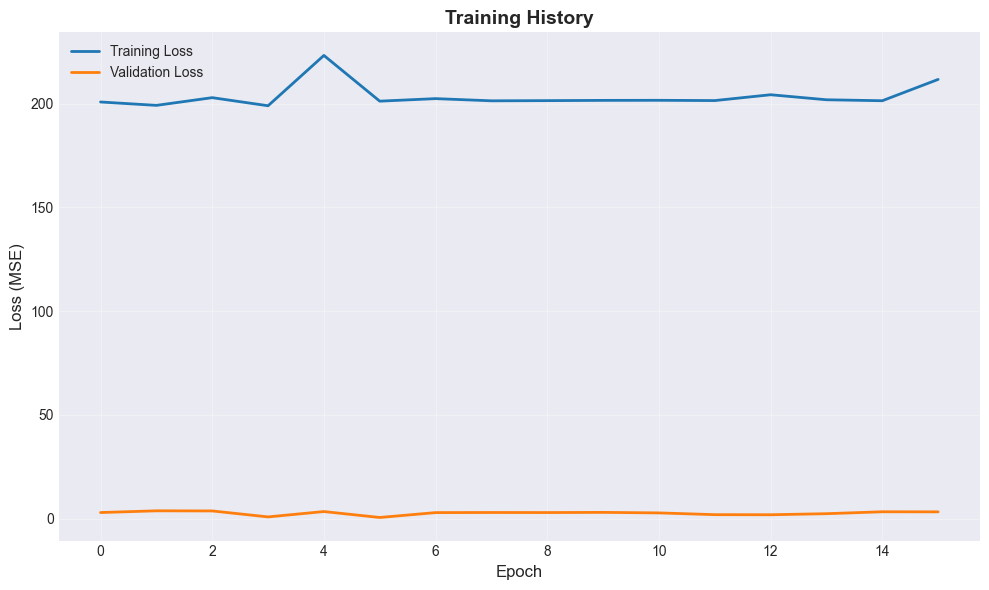


Final Training Loss: 211.720407
Final Validation Loss: 3.215935


In [16]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")

## 8. Evaluate & Backtest {#evaluate}

Test the model on held-out data and evaluate performance.

In [17]:
# Run backtest
results = trader.backtest(
    test_loader=test_loader,
    decision_threshold=0.0
)


BACKTEST RESULTS
Mean Squared Error:      217.447845
Mean Absolute Error:     5.878326
Directional Accuracy:    36.89%
Total Return:            2033.2139
Sharpe Ratio:            4.9304
Number of Trades:        450


In [18]:
# Print detailed results
print("\n" + "="*60)
print("DETAILED BACKTEST RESULTS")
print("="*60)

print(f"\n📊 Prediction Accuracy:")
print(f"  Mean Squared Error:      {results['mse']:.6f}")
print(f"  Mean Absolute Error:     {results['mae']:.6f}")
print(f"  Directional Accuracy:    {results['directional_accuracy']:.2%}")

print(f"\n💰 Trading Performance:")
print(f"  Total Return:            {results['total_return']:.4f}")
print(f"  Sharpe Ratio:            {results['sharpe_ratio']:.4f}")
print(f"  Number of Trades:        {results['n_trades']}")

# Calculate some additional metrics
win_rate = np.mean(results['signals'][:-1] * results['targets'][1:] > 0)
print(f"  Win Rate:                {win_rate:.2%}")

print("\n" + "="*60)


DETAILED BACKTEST RESULTS

📊 Prediction Accuracy:
  Mean Squared Error:      217.447845
  Mean Absolute Error:     5.878326
  Directional Accuracy:    36.89%

💰 Trading Performance:
  Total Return:            2033.2139
  Sharpe Ratio:            4.9304
  Number of Trades:        450
  Win Rate:                36.97%



## 9. Visualize Results {#visualize}

Create comprehensive visualizations of model performance.

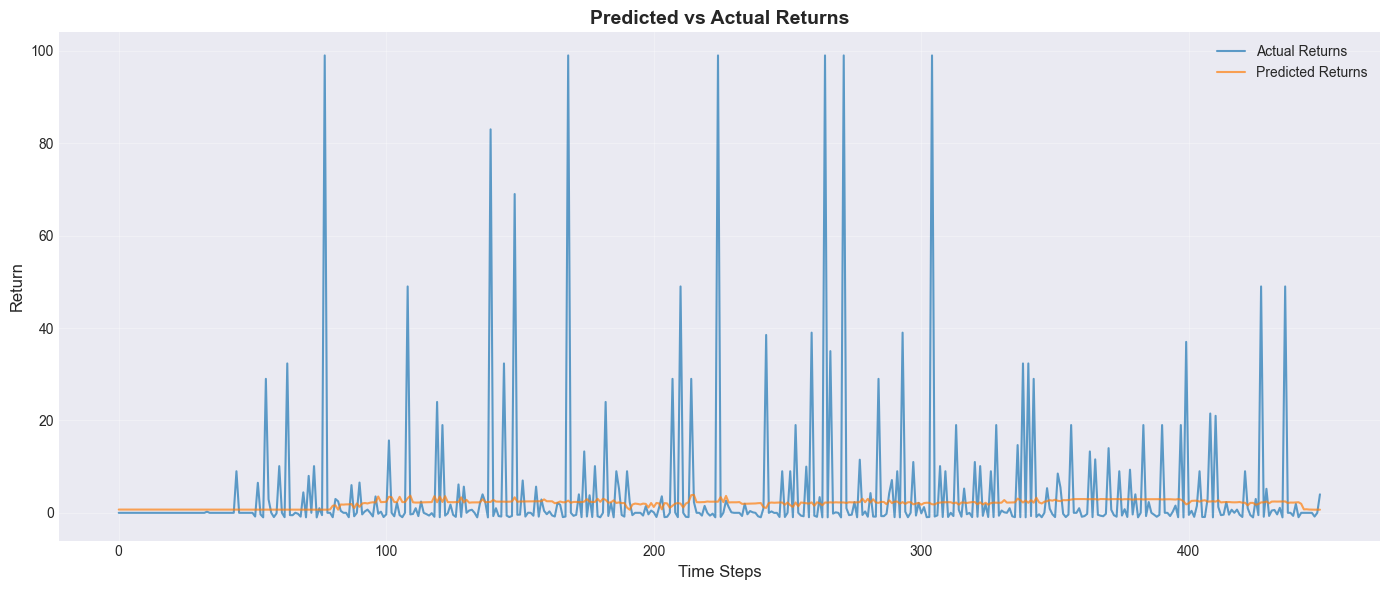

In [19]:
# Plot predictions vs actual
n_samples = min(500, len(results['predictions']))

plt.figure(figsize=(14, 6))
plt.plot(results['targets'][:n_samples], label='Actual Returns', alpha=0.7, linewidth=1.5)
plt.plot(results['predictions'][:n_samples], label='Predicted Returns', alpha=0.7, linewidth=1.5)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.title('Predicted vs Actual Returns', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

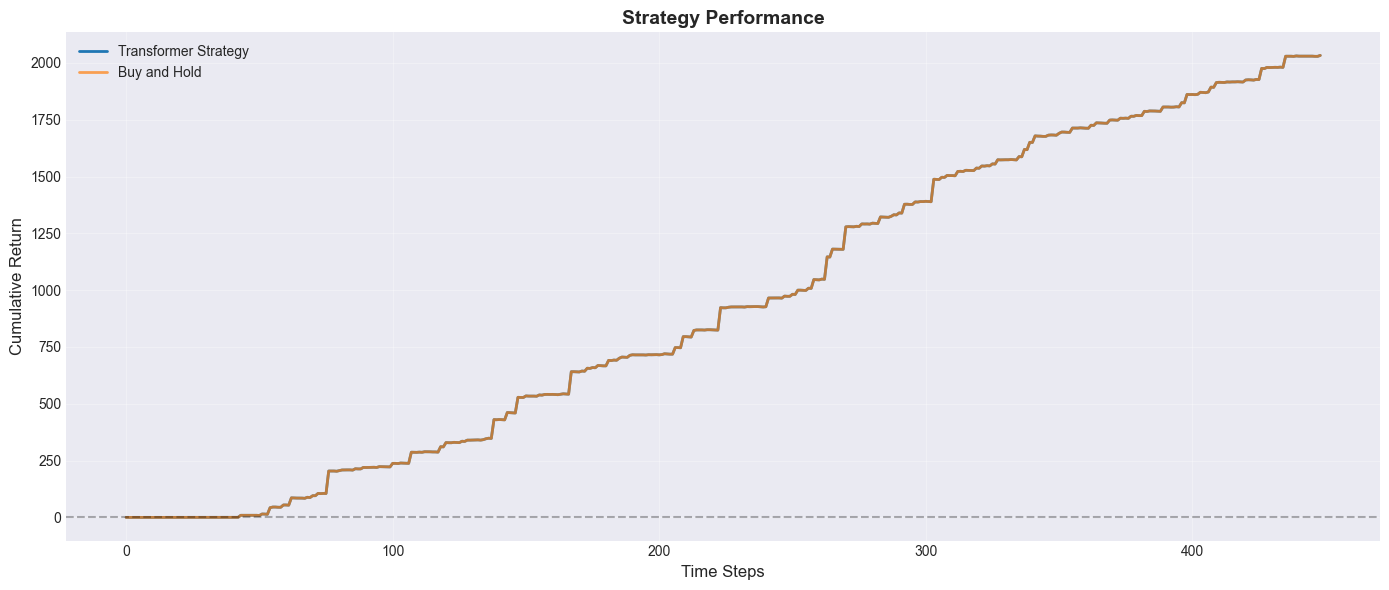


Transformer Strategy: 2033.2139
Buy and Hold:         2033.2139
Outperformance:       0.0000


In [20]:
# Plot cumulative returns
returns = results['signals'][:-1] * results['targets'][1:]
cumulative_returns = np.cumsum(returns)
buy_hold_returns = np.cumsum(results['targets'][1:])

plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns, label='Transformer Strategy', linewidth=2)
plt.plot(buy_hold_returns, label='Buy and Hold', linewidth=2, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.title('Strategy Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTransformer Strategy: {cumulative_returns[-1]:.4f}")
print(f"Buy and Hold:         {buy_hold_returns[-1]:.4f}")
print(f"Outperformance:       {cumulative_returns[-1] - buy_hold_returns[-1]:.4f}")

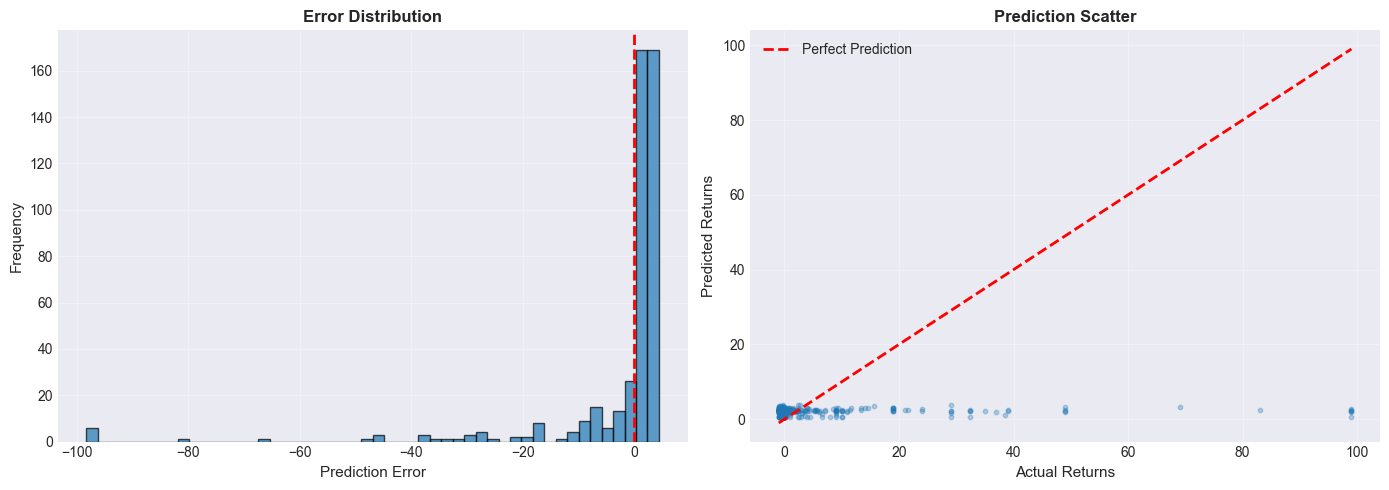

In [21]:
# Prediction error distribution
errors = results['predictions'] - results['targets']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of errors
ax1.hist(errors, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Prediction Error', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Scatter plot
ax2.scatter(results['targets'], results['predictions'], alpha=0.3, s=10)
ax2.plot([results['targets'].min(), results['targets'].max()], 
         [results['targets'].min(), results['targets'].max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Returns', fontsize=11)
ax2.set_ylabel('Predicted Returns', fontsize=11)
ax2.set_title('Prediction Scatter', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Experiments & Tuning {#experiments}

Try different configurations to optimize performance.

In [22]:
# Save the current model
trader.save_model('transformer_model_v1.pth')
print("✓ Model saved!")

Model saved to transformer_model_v1.pth
✓ Model saved!


### Experiment 1: Try Different Sequence Lengths

In [23]:
# Try different sequence lengths
sequence_lengths = [20, 30, 50, 100]
results_dict = {}

for seq_len in sequence_lengths:
    print(f"\n{'='*60}")
    print(f"Testing sequence length: {seq_len}")
    print(f"{'='*60}")
    
    # Create new trader
    temp_trader = TransformerTrader(
        sequence_length=seq_len,
        d_model=128,
        n_heads=8,
        n_layers=4,
        batch_size=32
    )
    
    # Prepare data
    train_l, val_l, test_l = temp_trader.prepare_data(
        df=df_features,
        feature_columns=feature_columns,
        target_column='future_return'
    )
    
    # Build and train
    temp_trader.build_model(n_features=len(feature_columns))
    temp_trader.train(train_l, val_l, n_epochs=20, patience=5)
    
    # Backtest
    res = temp_trader.backtest(test_l)
    results_dict[seq_len] = res
    
    print(f"Directional Accuracy: {res['directional_accuracy']:.2%}")
    print(f"Sharpe Ratio: {res['sharpe_ratio']:.4f}")


Testing sequence length: 20
Using device: cpu
Data split: Train=2331, Val=499, Test=500

Model Architecture:
  - Input features: 12
  - Model dimension: 128
  - Attention heads: 8
  - Encoder layers: 4
  - Total parameters: 803,073

Starting training...
Epoch    Train Loss   Val Loss     Status
--------------------------------------------------
1        192.587065   0.031186     ✓ Saved
5        198.889474   2.276471     

Early stopping triggered after 7 epochs

Training complete! Best validation loss: 0.005641

BACKTEST RESULTS
Mean Squared Error:      197.972595
Mean Absolute Error:     7.161328
Directional Accuracy:    34.58%
Total Return:            2033.0139
Sharpe Ratio:            4.7587
Number of Trades:        480
Directional Accuracy: 34.58%
Sharpe Ratio: 4.7587

Testing sequence length: 30
Using device: cpu
Data split: Train=2331, Val=499, Test=500

Model Architecture:
  - Input features: 12
  - Model dimension: 128
  - Attention heads: 8
  - Encoder layers: 4
  - Total pa


Comparison Results:
 Sequence Length  Directional Accuracy  Sharpe Ratio  Total Return
              20              0.345833      4.758669   2033.013871
              30              0.353191      4.814266   2033.213871
              50              0.364444      4.852862   2003.980537
             100              0.410000      5.237839   2023.963871


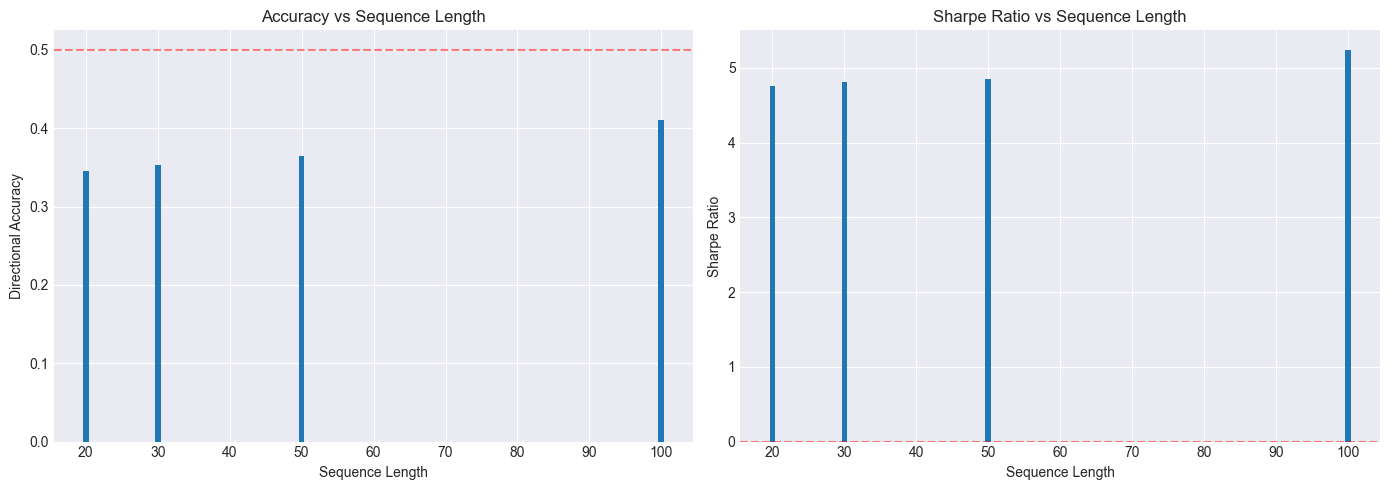

In [24]:
# Compare results
comparison_df = pd.DataFrame({
    'Sequence Length': list(results_dict.keys()),
    'Directional Accuracy': [results_dict[k]['directional_accuracy'] for k in results_dict.keys()],
    'Sharpe Ratio': [results_dict[k]['sharpe_ratio'] for k in results_dict.keys()],
    'Total Return': [results_dict[k]['total_return'] for k in results_dict.keys()]
})

print("\nComparison Results:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(comparison_df['Sequence Length'], comparison_df['Directional Accuracy'])
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Directional Accuracy')
axes[0].set_title('Accuracy vs Sequence Length')
axes[0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)

axes[1].bar(comparison_df['Sequence Length'], comparison_df['Sharpe Ratio'])
axes[1].set_xlabel('Sequence Length')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Sharpe Ratio vs Sequence Length')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Experiment 2: Try Different Time Intervals

In [ ]:
# Example: Try 5-minute bars instead of 1-minute
# df_ohlcv_5min = aggregate_to_bars(df_tick, interval='5min')
# df_features_5min = prepare_ml_features(df_ohlcv_5min)
# ... train and compare

## 📊 Summary & Next Steps

### What We Accomplished
- ✅ Loaded IEX DEEP tick data
- ✅ Aggregated to OHLCV bars
- ✅ Engineered 30+ features
- ✅ Built Transformer model
- ✅ Trained with early stopping
- ✅ Backtested on hold-out data
- ✅ Visualized results
- ✅ Experimented with hyperparameters

### Key Findings
(Fill in your results here)

### Next Steps
1. Train on multiple days of data
2. Compare with team models (XGBoost, TCN, LSTM)
3. Try ensemble approach
4. Implement risk management
5. Prepare presentation materials